# Setup

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

## Display

In [2]:
# Facebook Prophet gives a number of info/warning messages which can't be suppressed using standard context manager 
# techniques. This code allows hiding cells which contain stderr output, which includes the Prophet messages.

# From answer given by user matthiash on StackOverflow at https://stackoverflow.com/a/43118091 
# Full discussion: https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

## Data

In [3]:
volume_file_name = 'Data/two_way_volume_data.pkl'
two_way_volume_df = pd.read_pickle(volume_file_name)

In [4]:
pd.set_option('display.max_columns', None)
two_way_volume_df

station_id,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464,495,949,1335,1604,1940,3467,3790,3801,4820,4910,5984,6224
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,NaN,NaN,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,822.0,116.0,66.0,120.0,35.0,152.0,405.0,32.0,36.0,287.0,177.0,261.0,8.0,12.0,22.0,306.0,3.0,5.0,36.0,17.0,63.0,11.0,73.0,32.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,4144.0,2869.0,1489.0,2554.0,1824.0,2798.0,3251.0,2351.0,486.0,1405.0,1056.0,NaN,136.0,495.0,198.0,813.0,397.0,73.0,190.0,410.0,86.0,231.0,646.0,170.0,2.0,126.0,1874.0,358.0,73.0,541.0,507.0,129.0,128.0,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 01:00:00,NaN,NaN,157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,877.0,58.0,68.0,157.0,46.0,157.0,568.0,23.0,18.0,305.0,173.0,258.0,14.0,16.0,18.0,332.0,10.0,9.0,28.0,17.0,52.0,10.0,61.0,31.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,4761.0,3165.0,1453.0,3173.0,2230.0,3157.0,4074.0,2947.0,545.0,1549.0,1292.0,NaN,178.0,526.0,210.0,912.0,367.0,112.0,283.0,411.0,111.0,259.0,654.0,168.0,2.0,121.0,2322.0,378.0,56.0,523.0,440.0,111.0,105.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,472.0,49.0,57.0,83.0,19.0,92.0,395.0,20.0,17.0,242.0,131.0,179.0,1.0,16.0,19.0,130.0,0.0,7.0,16.0,8.0,30.0,3.0,34.0,13.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,2849.0,1773.0,773.0,2207.0,1362.0,1773.0,2385.0,1852.0,332.0,865.0,704.0,NaN,110.0,290.0,141.0,517.0,218.0,67.0,164.0,205.0,58.0,148.0,419.0,72.0,1.0,58.0,1444.0,212.0,35.0,326.0,235.0,77.0,68.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,NaN,NaN,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,353.0,48.0,39.0,81.0,10.0,61.0,255.0,14.0,2.0,160.0,73.0,135.0,2.0,5.0,12.0,90.0,3.0,11.0,11.0,8.0,31.0,2.0,28.0,9.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,1736.0,1069.0,461.0,1320.0,825.0,1069.0,1255.0,1146.0,206.0,509.0,405.0,NaN,38.0,173.0,85.0,310.0,173.0,32.0,94.0,134.0,25.0,88.0,240.0,49.0,3.0,41.0,870.0,131.0,12.0,213.0,122.0,29.0,40.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,NaN,NaN,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,296.0,59.0,28.0,75.0,13.0,43.0,168.0,4.0,2.0,142.0,74.0,101.0,1.0,2.0,8.0,82.0,0.0,3.0,5.0,1.0,17.0,2.0,30.0,9.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,1121.0,785.0,324.0,916.0,579.0,908.0,822.0,734.0,133.0,319.0,209.0,NaN,29.0,122.0,85.0,219.0,216.0,31.0,93.0,77.0,18.0,72.0,182.0,25.0,4.0,38.0,583.0,60.0,18.0,120.0,63.0,21.0,29.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 19:00:00,712.0,NaN,NaN,NaN,NaN,162.0,1234.0,129.0,NaN,NaN,NaN,858.0,219.0,NaN,NaN,1415.0,584.0,23.0,396.0,NaN,NaN,NaN,NaN,NaN,NaN,723.0,NaN,NaN,195.0,719.0,NaN,74.0,34.0,NaN,309.0,NaN,21.0,29.0,NaN,389.0,8.0,27.0,NaN,61.0,NaN,61.0,NaN,75.0,262.0,26.0,31.0,80.0,10.0,NaN,48.0,3598.0,3953.0,2383.0,NaN,NaN,NaN,NaN,NaN,NaN,2205.0,NaN,NaN,NaN,NaN,NaN,NaN,1126.0,NaN,2254.0,976.0,164.0,541.0,876.0,193.0,NaN,NaN,2550.0,NaN,81.0,1032.0,566.0,292.0,119.0,365.0,807.0,1542.0,471.0,NaN,138.0,NaN,935.0,7

A number of stations have very little data. For example, over a dozen stations have only been collecting from 2019 or later. These stations have almost no data that can be used for training. Consequently, they will be dropped. In particular, any station with 80% or more missing values will be dropped.

In [5]:
row_limit = pd.options.display.max_rows
pd.options.display.max_rows = None
print(two_way_volume_df.apply(lambda x: x.first_valid_index()))
pd.options.display.max_rows = row_limit

station_id
26     2007-01-01
27     2015-01-01
28     2002-01-01
29     2007-01-01
30     2007-01-01
31     2009-08-03
32     2013-01-01
33     2009-01-01
34     2009-01-01
35     2007-01-01
37     2019-01-01
38     2010-01-01
39     2010-01-15
40     2010-01-01
41     2011-01-01
42     2012-01-01
43     2012-01-01
44     2014-01-01
45     2014-01-15
46     2015-02-16
47     2019-01-01
48     2017-01-01
49     2017-01-01
51     2002-01-01
103    2002-01-01
110    2002-01-01
164    2002-01-01
175    2002-01-01
179    2002-01-01
187    2002-01-01
191    2002-01-01
198    2002-01-01
199    2002-01-01
200    2002-01-01
204    2002-01-01
208    2002-01-01
209    2002-01-01
210    2002-01-01
211    2002-01-01
212    2002-01-01
214    2002-01-01
218    2002-01-01
219    2002-01-01
220    2002-01-01
221    2002-01-01
222    2002-01-01
223    2002-01-01
225    2002-01-01
227    2002-01-01
228    2012-04-23
229    2012-07-02
230    2012-09-10
231    2012-07-24
232    2012-09-20
233    2012-12-10

In [6]:
new_stations = two_way_volume_df.apply(lambda x: x.isna().mean() >= 0.80)
new_stations = two_way_volume_df.columns[new_stations]
two_way_volume_df.drop(new_stations, axis=1, inplace=True)

Months with partial data will give outliers. To avoid this, they will be dropped and then imputed.

In [7]:
two_way_volume_missing_df = two_way_volume_df.isna()
two_way_volume_missing_df

station_id,26,27,28,29,31,32,33,34,35,38,39,40,41,42,43,44,45,46,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2002-01-01 01:00:00,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2002-01-01 02:00:00,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2002-01-01 03:00:00,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2002-01-01 04:00:00,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 19:00:00,False,True,True,True,False,False,False,True,True,False,False,True,True,False,False,False,False,True,True,True,False,True,True,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False
2021-02-28 20:00:00,False,True,True,True,False,False,False,True,True,False,False,True,True,False,False,False,False,True,True,True,False,True,True,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,True,False,Tru

In [8]:
two_way_volume_1M_missing_df = two_way_volume_missing_df.resample('1M').sum()
two_way_volume_1M_missing_df

station_id,26,27,28,29,31,32,33,34,35,38,39,40,41,42,43,44,45,46,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-31,744,744,0,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,744,744,744,744,744,744,0,0,0,0,0,0,0,0,0,0,0,744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-02-28,672,672,0,672,672,672,672,672,672,672,672,672,672,672,672,672,672,672,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,672,672,672,672,672,672,0,0,0,0,0,0,0,0,0,0,0,672,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-03-31,744,744,0,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,744,744,744,744,744,744,0,0,0,0,0,0,0,0,0,0,0,744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-04-30,720,720,0,720,720,720,720,720,720,720,720,720,720,720,720,720,720,720,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,720,720,720,720,720,720,0,0,0,0,0,0,0,0,0,0,0,720,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2002-05-31,744,744,0,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,744,744,744,744,744,744,0,0,0,0,0,0,0,0,0,0,0,744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-31,0,72,744,744,24,0,0,48,744,0,0,744,96,72,24,0,0,504,744,744,0,24,744,504,0,552,0,0,552,24,744,24,0,744,0,0,0,696,0,744,0,744,744,24,0,0,0,0,168,744,744,744,744,744,744,744,744,744,744,744,744,744,168,744,408,744,744,744,456,48,144,0,744,0,744,744,744,744,0,48,480,24,0,288
2020-11-30,0,720,720,720,720,72,0,120,720,24,0,720,720,0,672,720,0,720,120,720,24,48,720,552,24,240,24,24,192,48,720,48,24,720,24,24,24,696,24,720,24,720,96,72,24,24,24,24,48,408,720,720,720,720,720,720,720,720,720,720,720,720,288,720,408,720,456,720,192,48,144,24,720,24,720,720,720,720,24,720,216,24,24,288
2020-12-31,192,552,744,168,96,0,0,24,168,744,0,744,216,48,0,24,0,504,120,648,0,744,744,384,0,288,744,0,144,0,744,96,0,744,24,0,48,696,0,744,0,744,0,24,0,0,0,24,216,0,744,744,744,744,744,744,744,744,744,744,744,744,120,744,648,744,0,744,240,0,0,0,744,0,744,744,744,744,0,0,0,0,0,600


In [9]:
two_way_volume_1M_df = two_way_volume_df.resample('1M').sum(min_count=1)
two_way_volume_1M_df[two_way_volume_1M_missing_df > 0] = np.nan
two_way_volume_1M_df

station_id,26,27,28,29,31,32,33,34,35,38,39,40,41,42,43,44,45,46,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-31,NaN,NaN,298241.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8498.0,1263942.0,689842.0,219970.0,494694.0,54117.0,453036.0,1098658.0,60720.0,38653.0,948400.0,250359.0,753533.0,15670.0,29381.0,80519.0,574824.0,10369.0,18809.0,85712.0,41397.0,69783.0,34574.0,94922.0,68531.0,219778.0,NaN,NaN,NaN,NaN,NaN,NaN,4937603.0,4065473.0,2651638.0,2673156.0,3065925.0,4680085.0,4230680.0,2827750.0,1051942.0,2178032.0,1838219.0,NaN,385578.0,915864.0,532516.0,2043015.0,1002051.0,221479.0,649261.0,781754.0,180764.0,530082.0,1334983.0,282049.0,38653.0,712427.0,2839404.0,563409.0,76819.0,894294.0,693397.0,180016.0,195991.0,661398.0
2002-02-28,NaN,NaN,274416.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7434.0,1180992.0,637850.0,214481.0,461941.0,48302.0,427830.0,1033178.0,55579.0,33331.0,898297.0,228088.0,709250.0,13732.0,28839.0,78949.0,528570.0,9739.0,17832.0,85870.0,39872.0,67497.0,31182.0,94930.0,64509.0,211141.0,NaN,NaN,NaN,NaN,NaN,NaN,4616147.0,3752510.0,2434180.0,2426514.0,2822203.0,4351761.0,3868292.0,2661377.0,974695.0,1997340.0,1695366.0,NaN,346978.0,850808.0,500143.0,1934640.0,940994.0,205393.0,607806.0,717406.0,161822.0,475796.0,1221064.0,259956.0,36549.0,640113.0,2585907.0,512597.0,70629.0,831034.0,632847.0,169689.0,179342.0,592746.0
2002-03-31,NaN,NaN,295164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8721.0,1279058.0,755953.0,232122.0,546551.0,53988.0,482924.0,1145469.0,61050.0,36228.0,1017407.0,227368.0,843623.0,17183.0,29995.0,82738.0,570634.0,9674.0,18629.0,94206.0,42609.0,73778.0,34505.0,99755.0,69943.0,251037.0,NaN,NaN,NaN,NaN,NaN,NaN,5001162.0,4106714.0,2708350.0,2892287.0,3106308.0,4787864.0,4175895.0,2870150.0,1071252.0,2169141.0,1824818.0,NaN,384893.0,925487.0,565819.0,2157923.0,995441.0,231011.0,693153.0,771880.0,172081.0,520735.0,1275374.0,284543.0,39554.0,702905.0,2810985.0,539281.0,76152.0,922624.0,686016.0,176080.0,195061.0,656227.0
2002-04-30,NaN,NaN,289833.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10121.0,1309889.0,736954.0,238503.0,555732.0,60061.0,513648.0,1143232.0,67281.0,41955.0,1093114.0,246403.0,851493.0,17673.0,30016.0,84409.0,604490.0,9512.0,21419.0,89132.0,45563.0,77378.0,39368.0,104584.0,77132.0,259721.0,NaN,NaN,NaN,NaN,NaN,NaN,5101427.0,4212103.0,2831271.0,2902609.0,3240014.0,4827665.0,4305003.0,2971377.0,1110905.0,2255044.0,1949445.0,NaN,402826.0,1008714.0,588578.0,2197056.0,1047372.0,249025.0,720291.0,833297.0,186189.0,555449.0,1351400.0,312745.0,44449.0,716193.0,2915827.0,585214.0,84830.0,947092.0,724498.0,201132.0,205137.0,688441.0
2002-05-31,NaN,NaN,269033.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19027.0,1411907.0,804170.0,303938.0,682843.0,79087.0,670159.0,1356600.0,76006.0,50870.0,1276552.0,387650.0,933849.0,20134.0,36222.0,126544.0,643283.0,15345.0,30075.0,121092.0,66628.0,101459.0,71848.0,149292.0,97428.0,302317.0,NaN,NaN,NaN,NaN,NaN,NaN,5254259.0,4473397.0,2992887.0,2988629.0,3403719.0,4941137.0,4494154.0,3061713.0,1221485.0,2415784.0,2081137.0,NaN,464957.0,1154770.0,662859.0,2461452.0,1229645.0,301295.0,826780.0,933593.0,230609.0,619731.0,1349924.0,358951.0,58558.0,789482.0,3134554.0,706389.0,98856.0,1005459.0,791802.0,223416.0,230950.0,707878.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20

Finally, the 

In [10]:
two_way_volume_max = two_way_volume_1M_df.max().max() 
two_way_volume_1M_df /= two_way_volume_max
two_way_volume_1M_df

station_id,26,27,28,29,31,32,33,34,35,38,39,40,41,42,43,44,45,46,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-31,NaN,NaN,0.052486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001496,0.222437,0.121403,0.038712,0.087059,0.009524,0.079728,0.193349,0.010686,0.006802,0.166906,0.044060,0.132612,0.002758,0.005171,0.014170,0.101161,0.001825,0.003310,0.015084,0.007285,0.012281,0.006085,0.016705,0.012061,0.038678,NaN,NaN,NaN,NaN,NaN,NaN,0.868951,0.715468,0.466652,0.470439,0.539561,0.823631,0.744542,0.497646,0.185128,0.383304,0.323502,NaN,0.067856,0.161180,0.093716,0.359543,0.176347,0.038977,0.114261,0.137578,0.031812,0.093287,0.234939,0.049637,0.006802,0.125377,0.499697,0.099152,0.013519,0.157384,0.122028,0.031680,0.034492,0.116397
2002-02-28,NaN,NaN,0.048293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001308,0.207839,0.112253,0.037746,0.081295,0.008500,0.075292,0.181825,0.009781,0.005866,0.158088,0.040140,0.124818,0.002417,0.005075,0.013894,0.093021,0.001714,0.003138,0.015112,0.007017,0.011879,0.005488,0.016706,0.011353,0.037158,NaN,NaN,NaN,NaN,NaN,NaN,0.812379,0.660391,0.428383,0.427034,0.496669,0.765851,0.680767,0.468366,0.171533,0.351505,0.298361,NaN,0.061063,0.149731,0.088018,0.340470,0.165602,0.036146,0.106966,0.126254,0.028478,0.083734,0.214891,0.045749,0.006432,0.112651,0.455085,0.090210,0.012430,0.146251,0.111372,0.029863,0.031562,0.104315
2002-03-31,NaN,NaN,0.051945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001535,0.225097,0.133037,0.040850,0.096186,0.009501,0.084988,0.201587,0.010744,0.006376,0.179050,0.040014,0.148466,0.003024,0.005279,0.014561,0.100424,0.001702,0.003278,0.016579,0.007499,0.012984,0.006072,0.017556,0.012309,0.044179,NaN,NaN,NaN,NaN,NaN,NaN,0.880137,0.722726,0.476633,0.509003,0.546668,0.842599,0.734901,0.505107,0.188526,0.381739,0.321143,NaN,0.067736,0.162873,0.099576,0.379765,0.175184,0.040655,0.121986,0.135840,0.030284,0.091642,0.224449,0.050076,0.006961,0.123702,0.494695,0.094906,0.013402,0.162369,0.120730,0.030988,0.034328,0.115487
2002-04-30,NaN,NaN,0.051007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001781,0.230523,0.129694,0.041973,0.097801,0.010570,0.090395,0.201193,0.011841,0.007384,0.192373,0.043364,0.149851,0.003110,0.005282,0.014855,0.106382,0.001674,0.003769,0.015686,0.008018,0.013617,0.006928,0.018405,0.013574,0.045707,NaN,NaN,NaN,NaN,NaN,NaN,0.897782,0.741273,0.498265,0.510820,0.570199,0.849604,0.757622,0.522922,0.195504,0.396857,0.343076,NaN,0.070892,0.177520,0.103582,0.386652,0.184323,0.043825,0.126761,0.146649,0.032767,0.097751,0.237828,0.055039,0.007822,0.126040,0.513146,0.102990,0.014929,0.166675,0.127502,0.035397,0.036101,0.121156
2002-05-31,NaN,NaN,0.047346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003348,0.248476,0.141523,0.053489,0.120171,0.013918,0.117939,0.238743,0.013376,0.008952,0.224656,0.068221,0.164345,0.003543,0.006375,0.022270,0.113209,0.002701,0.005293,0.021311,0.011726,0.017855,0.012644,0.026273,0.017146,0.053204,NaN,NaN,NaN,NaN,NaN,NaN,0.924678,0.787257,0.526708,0.525958,0.599008,0.869573,0.790910,0.538820,0.214965,0.425145,0.366252,NaN,0.081826,0.203224,0.116654,0.433182,0.216401,0.053024,0.145502,0.164300,0.040584,0.109064,0.237568,0.063171,0.010305,0.138938,0.551639,0.124315,0.017397,0.176947,0.139346,0.039318,0.040644,0.124577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020

In [11]:
two_way_volume_1M_df.describe()

station_id,26,27,28,29,31,32,33,34,35,38,39,40,41,42,43,44,45,46,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464
count,132.000000,38.000000,204.000000,123.000000,87.000000,71.000000,126.000000,119.000000,135.000000,108.000000,116.000000,96.000000,84.000000,86.000000,83.000000,59.000000,67.000000,38.000000,196.000000,173.000000,193.000000,212.000000,202.000000,202.000000,210.000000,205.000000,221.000000,212.000000,190.000000,200.000000,202.000000,210.000000,217.000000,193.000000,212.000000,206.000000,194.000000,205.000000,217.000000,204.000000,213.000000,158.000000,214.000000,190.000000,94.000000,96.000000,95.000000,87.000000,85.000000,77.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,202.000000,203.000000,204.000000,179.000000,203.000000,215.000000,201.000000,190.000000,219.000000,133.000000,201.000000,218.000000,210.000000,216.000000,203.000000,222.000000,187.000000,197.000000,203.000000,193.000000,224.000000,215.000000,218.000000,224.000000,223.000000,206.000000
mean,0.106760,0.030432,0.049054,0.042925,0.029065,0.151717,0.026301,0.016535,0.029938,0.157415,0.055364,0.290562,0.002435,0.166195,0.086923,0.005057,0.066315,0.002218,0.002612,0.241408,0.136270,0.049098,0.120126,0.011217,0.111354,0.231109,0.014115,0.007878,0.226220,0.055419,0.163531,0.003332,0.006101,0.019929,0.117409,0.002157,0.004563,0.018642,0.010476,0.016029,0.009205,0.023061,0.015054,0.049954,0.004026,0.005659,0.013218,0.001659,0.001820,0.007124,0.844976,0.714204,0.543688,0.488929,0.589333,0.850822,0.715024,0.486998,0.235585,0.420831,0.366048,0.610830,0.074834,0.184904,0.117764,0.443982,0.210521,0.057709,0.150300,0.162255,0.035635,0.102942,0.229871,0.053466,0.009936,0.108728,0.478617,0.096833,0.016030,0.154340,0.120611,0.047356,0.029947,0.108486
std,0.015813,0.006017,0.006614,0.009556,0.003762,0.018924,0.002962,0.003489,0.003931,0.033721,0.006142,0.032002,0.000972,0.018751,0.014316,0.001431,0.007583,0.000331,0.001339,0.024140,0.011631,0.009594,0.020829,0.002068,0.022148,0.031735,0.002239,0.001496,0.035685,0.013996,0.020699,0.000529,0.001012,0.005396,0.018294,0.000805,0.001012,0.003572,0.003414,0.004216,0.003127,0.006005,0.003100,0.009675,0.001185,0.000824,0.002538,0.000481,0.000516,0.001831,0.048031,0.056080,0.049244,0.045065,0.052700,0.066326,0.055751,0.060296,0.026384,0.031804,0.049636,0.047920,0.007403,0.018972,0.014147,0.050009,0.021795,0.010723,0.021107,0.021494,0.005426,0.010328,0.042758,0.009245,0.001782,0.010822,0.072138,0.014218,0.002697,0.011343,0.011371,0.005703,0.005559,0.011369
min,0.057884,0.010913,0.021617,0.028703,0.020886,0.084354,0.016239,0.000363,0.023231,0.077467,0.037318,0.217448,0.001292,0.115007,0.052930,0.002937,0.047370,0.001452,0.001022,0.197266,0.084037,0.021351,0.081088,0.000152,0.075027,0.164285,0.009415,0.005504,0.148050,0.030220,0.117815,0.002042,0.004127,0.012345,0.085978,0.001082,0.001478,0.012663,0.005854,0.010580,0.004479,0.015644,0.009744,0.029905,0.002234,0.003497,0.008010,0.000690,0.000981,0.004610,0.703756,0.557920,0.424760,0.360381,0.456692,0.687583,0.496399,0.289395,0.171533,0.334891,0.159409,0.492251,0.057346,0.142509,0.078514,0.218008,0.155472,0.036146,0.089872,0.121183,0.023218,0.079370,0.133000,0.000000,0.006432,0.079770,0.141059,0.067552,0.007447,0.112979,0.078445,0.027957,0.009223,0.069168
25%,0.099165,0.026344,0.045526,0.035389,0.026166,0.139803,0.024281,0.014770,0.026776,0.140808,0.049930,0.269338,0.001802,0.150245,0.074546,0.003760,0.060262,0.001961,0.001491,0.222262,0.128764,0.041586,0.103935,0.010059,0.092475,0.204471,0.012587,0.006757,0.196237,0.043138,0.150813,0.003035,0.005281,0.015015,0.105664,0.001405,0.003818,0.015574,0.007444,0.012537,0.006035,0.017696,0.012530,0.043099,0.002879,0.005043,0.011392,0.001244,0.001356,0.005820,0.810232,0.676342,0.512

## Train/Test Split

Set aside the last 20% of the dates for the test set. The training set is the first 80% of dates. This is the primary reason that stations with 80% or more missing data were dropped earlier.

In [12]:
test_pct = 0.2
train_pct = 1 - test_pct
split_idx = int(train_pct * len(two_way_volume_1M_df))
train_df = two_way_volume_1M_df.iloc[:split_idx,:]
test_df = two_way_volume_1M_df.iloc[split_idx:,:]

In [13]:
print(f"Train frame length: {len(train_df)}")
print(f"Test frame length: {len(test_df)}")
print(f"Total length: {len(train_df) + len(test_df)}")
print(f"Matches full frame length: {len(train_df) + len(test_df) == len(two_way_volume_1M_df)}")

Train frame length: 184
Test frame length: 46
Total length: 230
Matches full frame length: True


The training data is missing on average about 18.8% of the data.

In [14]:
train_df.isna().mean().sort_values()

station_id
464    0.000000
329    0.000000
208    0.000000
209    0.000000
210    0.000000
         ...   
32     0.717391
44     0.782609
45     0.788043
27     0.847826
46     0.858696
Length: 84, dtype: float64

In [15]:
train_df.isna().mean().mean()

0.18821169772256732

## Validation

Data is randomly dropped from each column of the training set for validation purposes. Each column has the same proportion of non-null data removed. Since there are many stations with high percentages of missing data, the proportion of removed values is kept high. Experimentation determined that the maximum workable holdout percentage was 50%. This percentage was then used for cross-validation purposes.

In [21]:
# General technique for generate_validation_column modified from answer given by user nocibambi on StackOverflow: 
# https://stackoverflow.com/a/54330885
# Full discussion: https://stackoverflow.com/questions/54330454/randomly-introduce-nan-values-in-pandas-dataframe

# The holdout_pct for validation is kept high because of the large percentage of missing data from a handful of stations.
# The holdout percentage and max iterations are taken by experiment. Setting holdout_pct to be larger makes it difficult
# or even impossible to correctly generate validation dataframes. Setting the max iterations to 2000 reduces the likelihood
# of function failure to well less than 0.1%.
holdout_pct = 0.5
maxiters = 2000
def generate_validation_column(col, holdout_pct=holdout_pct, maxiters=maxiters):
    iters = 0
    while True:
        col_c = col.copy()
        vals_to_nan = col_c.dropna().sample(frac=holdout_pct).index
        col_c.loc[vals_to_nan] = np.NaN
        
        # Verify that every month is represented in the validation (non-withheld) set.
        non_nan_months = set(col_c.dropna().index.month)
        if non_nan_months == set(range(1,13)):
            break
        
        # At least one month was omitted. Retry if we haven't reached the maximum number of iterations.
        iters += 1
        if iters >= maxiters:
            raise RuntimeError(f"Max iterations reached (maxiters={maxiters})")
    
    return col_c
    
def generate_validation_frame(df, holdout_pct=holdout_pct, maxiters=maxiters):
    df = df.copy()
    for col in df:
        df[col] = generate_validation_column(df[col], holdout_pct=holdout_pct, maxiters=maxiters)
        
    return df

In [22]:
def score_imputation_column(col, imputed_col, scorer):
    # It is possible for a column to have null entries before holding out values for validation. These should be ignored
    # for the purposes of scoring.
    df = pd.DataFrame({'orig': col, 'imp': imputed_col})
    df.dropna(inplace=True)
    
    score = scorer(df['orig'], df['imp'])
    return score

def single_score_imputation(df, imputed_df, scorer):
    score = 0
    for col in df:
        score += score_imputation_column(df[col], imputed_df[col], scorer=scorer)
    return score   

def score_imputation(df, imputed_df, scorers):
    if isinstance(scorers, list):
        scores = {}
        for scorer in scorers:
            score = single_score_imputation(df, imputed_df, scorer=scorer)
            scores[scorer.__name__] = score
        return scores
    else:
        return single_score_imputation(df, imputed_df, scorer=scorers)

def evaluate_imputation(df, imputer, scorers, holdout_pct=holdout_pct, maxiters=maxiters):
    val_df = generate_validation_frame(df, holdout_pct=holdout_pct, maxiters=maxiters)
    imputed_df = imputer(val_df)
    score = score_imputation(df, imputed_df, scorers=scorers)   
    return score

In [23]:
default_iters = 5
def evaluate_imputation_method(df, imputer, scorers=[mean_squared_error, mean_absolute_error], 
                               holdout_pct=holdout_pct, iterations=default_iters, maxiters=maxiters):  
    score_list = []
    for i in range(iterations):
        score = evaluate_imputation(df, imputer, scorers=scorers, holdout_pct=holdout_pct, maxiters=maxiters)
        score_list.append(score)
    
    if isinstance(scorers, list):
        scores = {}
        for scorer in scorers:
            subscore_list = [score[scorer.__name__] for score in score_list]
            scores[scorer.__name__] = np.mean(subscore_list)
        return scores
    else:
        return np.mean(score_list)

# Imputation Methods

## Fill with Mean

The first imputation method checked simply fills every column with the mean of all non-null entries. 

In [16]:
def mean_full(df):
    df = df.copy()
    df.fillna(df.mean(), inplace=True)
    return df

In [17]:
%%time
mean_df = mean_full(train_df)

Wall time: 12.7 ms


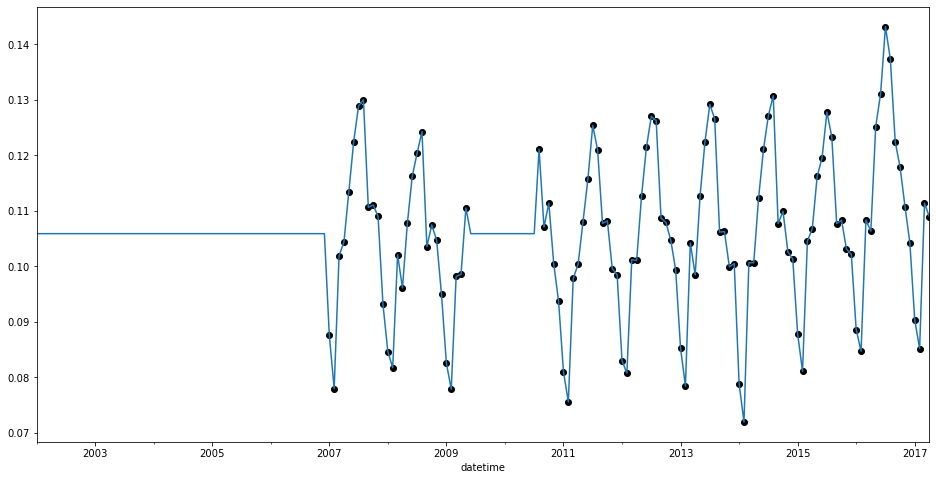

In [18]:
idx = '26'
mean_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [24]:
%%time
val_df = generate_validation_frame(train_df, holdout_pct=holdout_pct)
mean_holdout_df = mean_full(val_df)

Wall time: 174 ms


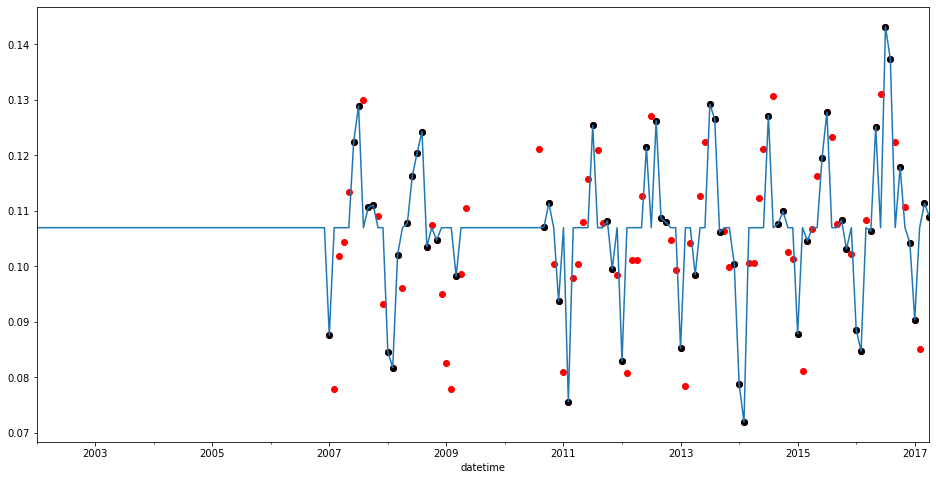

In [25]:
mean_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [26]:
validation_scores = {}

In [27]:
%%time
score = evaluate_imputation_method(train_df, mean_full)
validation_scores['mean'] = score

Wall time: 3.03 s


In [28]:
for key, val in validation_scores['mean'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 0.023
mean_absolute_error: 0.534


## Fill with Seasonal Mean

Next, a seasonal approach was taken to filling with the mean. Since the data exhibits a strong annual seasonality, the values were split into 12 groups, one for each month. For example, the January group contained the traffic volumes for January 2002, January 2003, January 2004, etc. Within each group, values were imputed by the mean of that month's entries.

In [29]:
def seasonal_split(df):
    df = df.copy()
    
    # Split the dataframe into subframes with one frame for each month
    index_frequencies = [ 'A-JAN', 'A-FEB', 'A-MAR', 'A-APR', 'A-MAY', 'A-JUN', 'A-JUL', 'A-AUG', 
                     'A-SEP', 'A-OCT', 'A-NOV', 'A-DEC']
    date_ranges = [ pd.date_range(start=df.first_valid_index(), end=df.last_valid_index(), freq=freq) \
                   for freq in index_frequencies]
    
    subframes = [ df.loc[date_range] for date_range in date_ranges ]
    
    return subframes

In [30]:
def mean_seasonal(df):
    subframes = seasonal_split(df)
    
    recovered_frames = []
    for sub_df in subframes:
        recovered = mean_full(sub_df)
        recovered_frames.append(recovered)
        
    recovered_df = pd.concat(recovered_frames)
    recovered_df.sort_index(inplace=True)

    return recovered_df

In [31]:
%%time
mean_seasonal_df = mean_seasonal(train_df)

Wall time: 202 ms


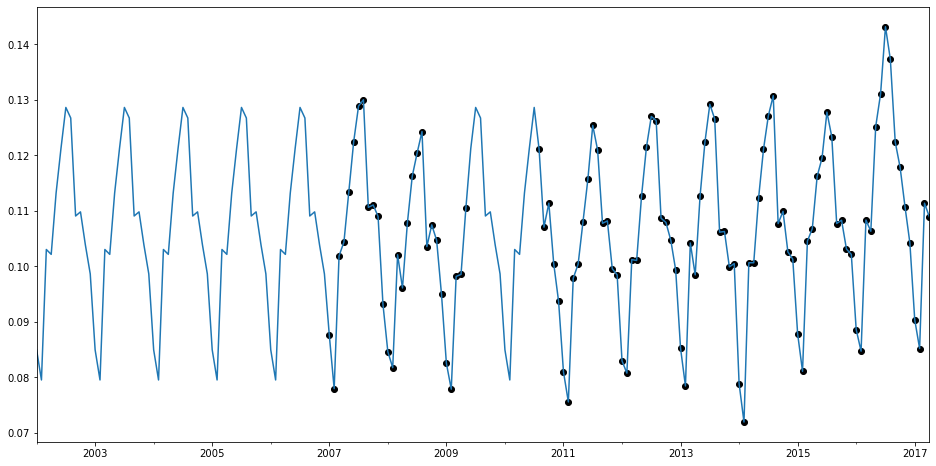

In [32]:
mean_seasonal_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [31]:
%%time
mean_seasonal_holdout_df = mean_seasonal(val_df)

Wall time: 141 ms


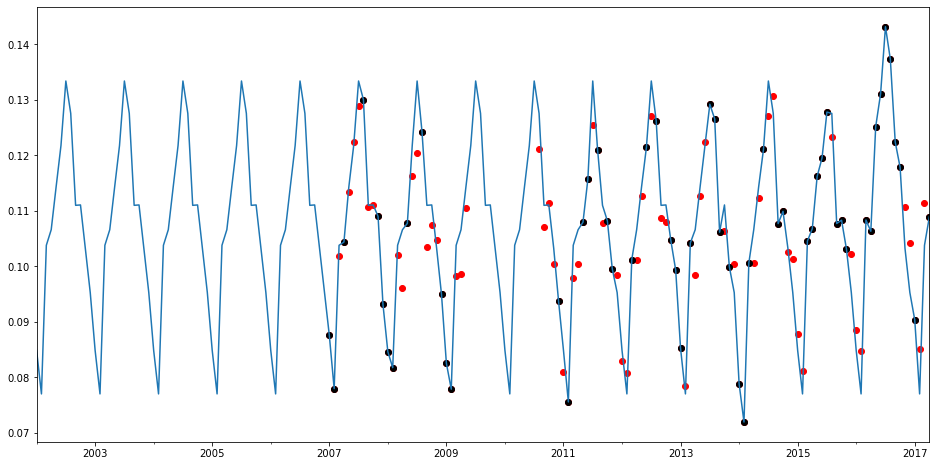

In [32]:
mean_seasonal_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [33]:
%%time
score = evaluate_imputation_method(train_df, mean_seasonal)
validation_scores['seasonal_mean'] = score

Wall time: 3.31 s


In [34]:
for key, val in validation_scores['seasonal_mean'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 0.016
mean_absolute_error: 0.373


## CDRec

The next imputation techniques attempt to utilize the correlation between individual time series. The particular method used was a particular Centroid Decomposition (CD) algorithm named CDRec by its developers (Khayati, Cudré-Mauroux & Böhlen). This method is described in the article [Scalable recovery of missing blocks in time series with high and low cross-correlations](https://link.springer.com/article/10.1007/s10115-019-01421-7). An implementation is maintained on Github by the [first author](https://github.com/eXascaleInfolab/cdrec).

The algorithm is slightly modified to prevent negative values by replacing any negative values with zero.

In [35]:
# CDRec is available on Github at https://github.com/eXascaleInfolab/cdrec
# The file run here is identical to the one found in commit 2083ee9 on Github except the function main and its execution
# were removed as unnecessary.
%run recovery.py

In [36]:
def cdrec_full(df, truncation=1, maxIterations=100, threshold=1E-6):
    df = df.copy()
    # If the time series begins with a null value, the CDRec method puts an impossibly large value in the first entry.
    # Add an initial null value to every time series that will be dropped in order to account for this.
    df.loc[pd.Timestamp('2001-12-31 00:00:00', freq='M'),:] = np.nan
    df.sort_index(inplace=True)
    
    # Apply the CDRec algorithm
    recovered = centroid_recovery(df, truncation=truncation, maxIterations=maxIterations, threshold=threshold)
    recovered_df = pd.DataFrame(recovered)
    recovered_df.columns = df.columns
    recovered_df.index = df.index
    
    # There's a possibility that the imputed values drop below 0. Since this is physically impossible, replace negative
    # values with 0
    recovered_df[recovered_df < 0] = 0
    
    # Drop the initial null values
    recovered_df = recovered_df['2002-01-31':]

    return recovered_df

In [37]:
%%time
cdrec_df = cdrec_full(train_df)

Wall time: 5.44 s


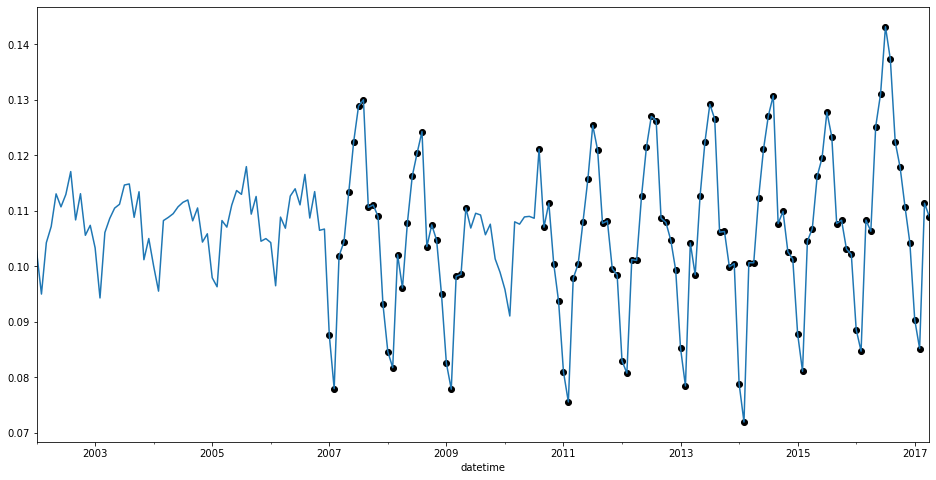

In [38]:
cdrec_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [39]:
%%time
cdrec_holdout_df = cdrec_full(val_df)

Wall time: 5.6 s


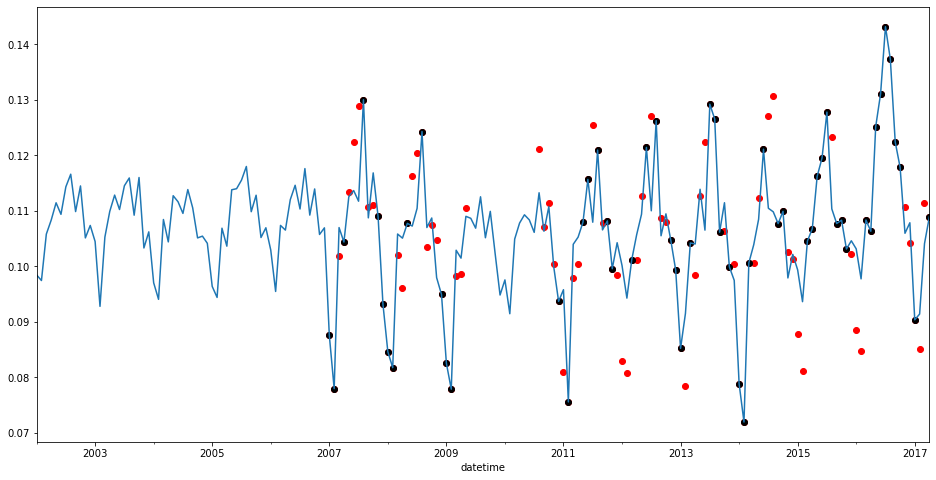

In [40]:
cdrec_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [41]:
%%time
score = evaluate_imputation_method(train_df, cdrec_full)
validation_scores['cdrec'] = score

Wall time: 30.3 s


In [42]:
for key, val in validation_scores['cdrec'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 0.017
mean_absolute_error: 0.413


## CDRec - Seasonal

The imputation plotted above makes it appear as if the full range of seasonal fluctuation is not being captured. The same seasonal modification used in the seasonal mean is attempted here. The idea is that by focusing on the monthly subframes, the seasonality may be reproduced.

In [43]:
def cdrec_monthly(df, truncation=1, maxIterations=100, threshold=1E-6):
    df = df.copy()
    
    # Split the dataframe into subframes with one frame for each month
    index_frequencies = [ 'A-JAN', 'A-FEB', 'A-MAR', 'A-APR', 'A-MAY', 'A-JUN', 'A-JUL', 'A-AUG', 
                     'A-SEP', 'A-OCT', 'A-NOV', 'A-DEC']
    date_ranges = [ pd.date_range(start=df.first_valid_index(), end=df.last_valid_index(), freq=freq) \
                   for freq in index_frequencies]
    
    subframes = [ df.loc[date_range] for date_range in date_ranges ]
    
    recovered_frames = []
    for sub_df in subframes:
        recovered = cdrec_full(sub_df, truncation=truncation, maxIterations=maxIterations, threshold=threshold)
        recovered_frames.append(recovered)
        
    recovered_df = pd.concat(recovered_frames)
    recovered_df.sort_index(inplace=True)

    return recovered_df

In [44]:
%%time
cdrec_seasonal_df = cdrec_monthly(train_df)

Wall time: 5.68 s


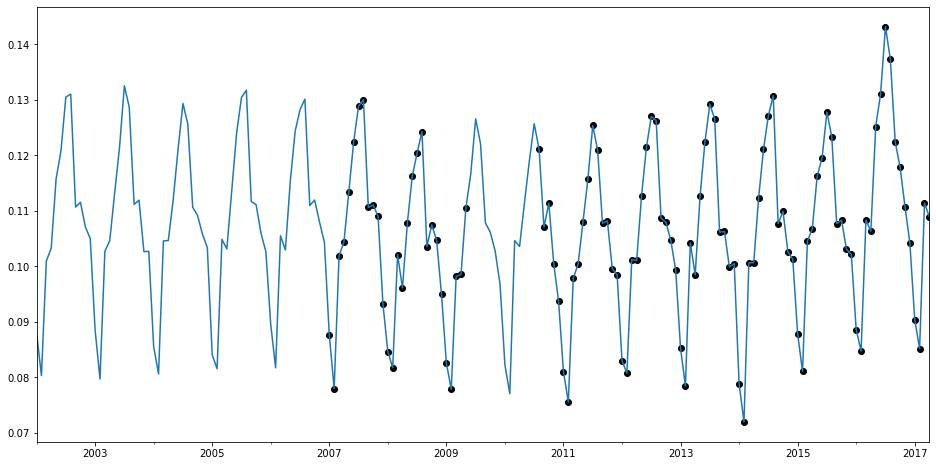

In [45]:
cdrec_seasonal_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [46]:
%%time
cdrec_seasonal_holdout_df = cdrec_monthly(val_df)

Wall time: 5.7 s


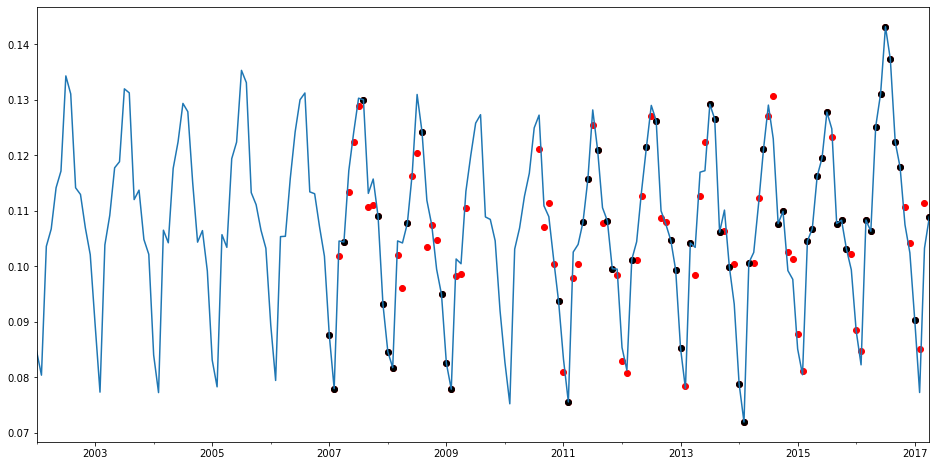

In [47]:
cdrec_seasonal_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [48]:
%%time
score = evaluate_imputation_method(train_df, cdrec_monthly)
validation_scores['seasonal_cdrec'] = score

Wall time: 30.6 s


In [49]:
for key, val in validation_scores['seasonal_cdrec'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 0.017
mean_absolute_error: 0.373


## Prophet

Facebook Prophet can be used for imputation, so that is attempted here. Initially, the linear algorithm is used with a correction of changing any calculated negative values to zero. Prophet is independently applied to each column.

In [50]:
# Prophet expects a data frame with 2 columns. One column 'ds' with the time stamps and one column 'y' with the data.
def produce_prophet_series(y, logistic=False):
    if logistic:
        df = pd.DataFrame({'ds': y.index, 'y':y})
        df['cap'] = 10
        df['floor'] = 0   
    else:
        df = pd.DataFrame({'ds': y.index, 'y':y})
    return df

In [51]:
def prophet(df, logistic=False):
    df = df.copy()
    predicted_df = pd.DataFrame(index=df.index) 
    for col in df:
        prop = produce_prophet_series(df[col], logistic=logistic)
        if logistic:
            model = Prophet(daily_seasonality=False, weekly_seasonality=False, growth='logistic')
        else:
            model = Prophet(daily_seasonality=False, weekly_seasonality=False)
        model.fit(prop)
        # Since future forecasts aren't desired, set periods = 0, which will produce a model on the timeframe covered by df
        prediction_frame = model.make_future_dataframe(periods=0, freq='M')
        if logistic:
            prediction_frame['cap'] = 10
            prediction_frame['floor'] = 0
        prediction = model.predict(prediction_frame)
        yhat = prediction['yhat']
        yhat.index = predicted_df.index
        predicted_df[col] = yhat
    
    # Make sure that any negative values are trimmed to 0
    predicted_df[predicted_df < 0] = 0
    # At this point, Prophet is only being used for imputing, so only the null values from df should be different from df
    predicted_df[df.notna()] = df
    return predicted_df

In [52]:
%%time
prophet_df = prophet(train_df)

INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


Wall time: 2min 25s


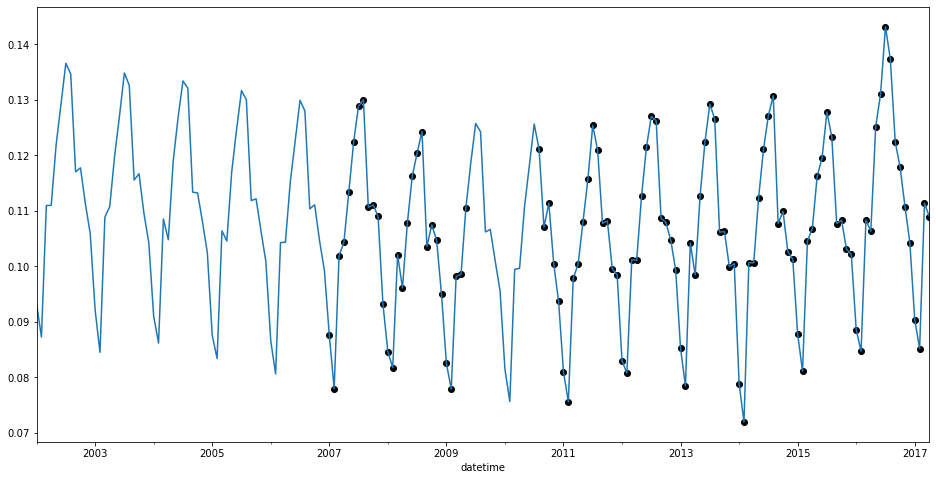

In [53]:
prophet_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [54]:
%%time
prophet_holdout_df = prophet(val_df)

INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


Wall time: 7min 40s


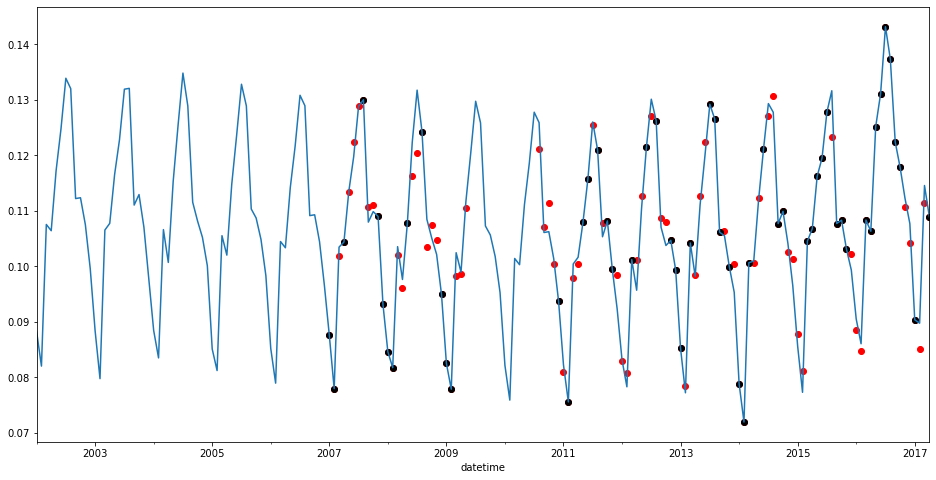

In [55]:
prophet_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [56]:
%%time
score = evaluate_imputation_method(train_df, prophet)
validation_scores['prophet'] = score

INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 20.

Wall time: 44min 47s


In [57]:
for key, val in validation_scores['prophet'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 0.021
mean_absolute_error: 0.352


## Prophet with Logistic Floor

Finally, the logistic algorithm for Prophet is used along with a floor of 0.

In [58]:
%%time
prophet_logistic_df = prophet(train_df, logistic=True)

INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


Wall time: 5min 22s


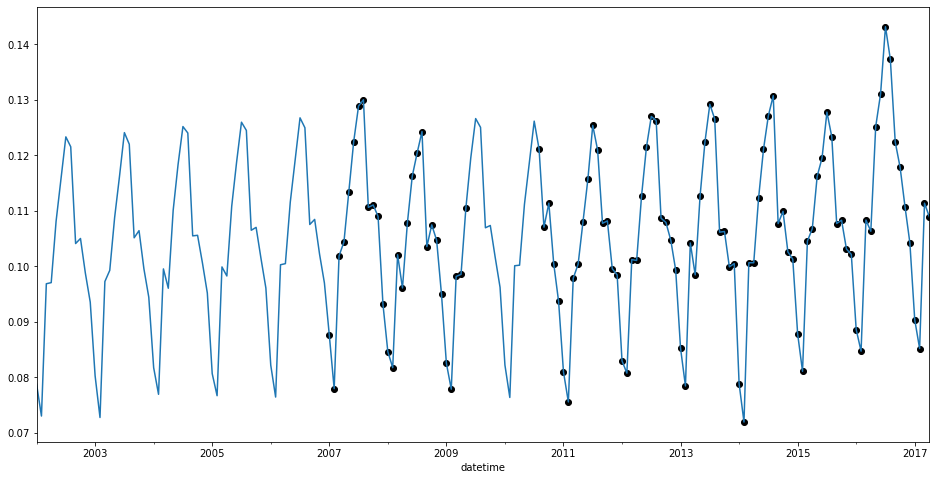

In [59]:
prophet_logistic_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='k');

In [60]:
%%time
prophet_logistic_holdout_df = prophet(val_df, logistic=True)

INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


Wall time: 11min 10s


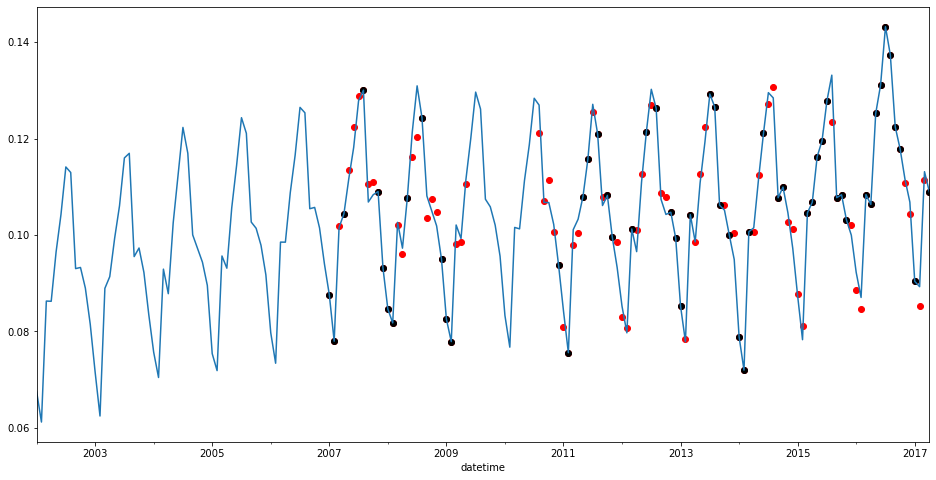

In [61]:
prophet_logistic_holdout_df[idx].plot(figsize=(16,8));
plt.scatter(x=train_df.index, y=train_df[idx], color='r');
plt.scatter(x=val_df.index, y=val_df[idx], color='k');

In [62]:
%%time
score = evaluate_imputation_method(train_df, lambda x: prophet(x, logistic=True))
validation_scores['logistic_prophet'] = score

INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 20.

Wall time: 55min 14s


In [63]:
for key, val in validation_scores['logistic_prophet'].items():
    print(f"{key}: {val:0.3f}")

mean_squared_error: 0.039
mean_absolute_error: 0.392


# Evaluation

In [64]:
mse_scores = { key: value['mean_squared_error'] for key, value in validation_scores.items() }
mae_scores = { key: value['mean_absolute_error'] for key, value in validation_scores.items() }

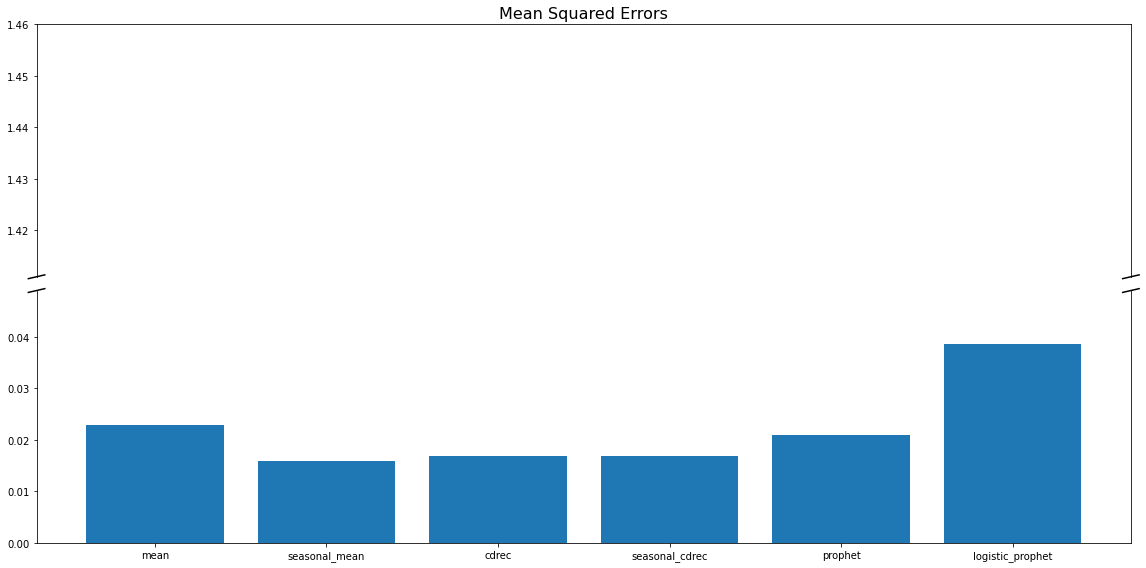

In [65]:
# Modified from example found in matplotlib documentation at 
# https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/broken_axis.html
x_axis = list(mse_scores.keys())
# Setup two plots, one for outliers, other for the larger set.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,8), sharex=True)
# Plot same data in both plots.
ax1.bar(x=x_axis, height=mse_scores.values());
ax2.bar(x=x_axis, height=mse_scores.values());
# Scale the plots identically and set limits to capture the differences.
ax1.set_ylim(1.411, 1.46);
ax2.set_ylim(0, .049);
# Remove interior sides of plot boxes.
ax1.spines['bottom'].set_visible(False);
ax2.spines['top'].set_visible(False);
# Remove ticks and labels from between the plots.
ax1.xaxis.set_ticks_position('none');
ax1.tick_params(labeltop=False);
ax2.xaxis.tick_bottom();

# Add diagonal lines at breaks.
d = .0075  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False);
ax1.plot((-d, +d), (-d, +d), **kwargs);        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs);  # top-right diagonal
kwargs.update(transform=ax2.transAxes);  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs);  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs);  # bottom-right diagonal

ax1.set_title('Mean Squared Errors', fontsize=16);
plt.tight_layout();

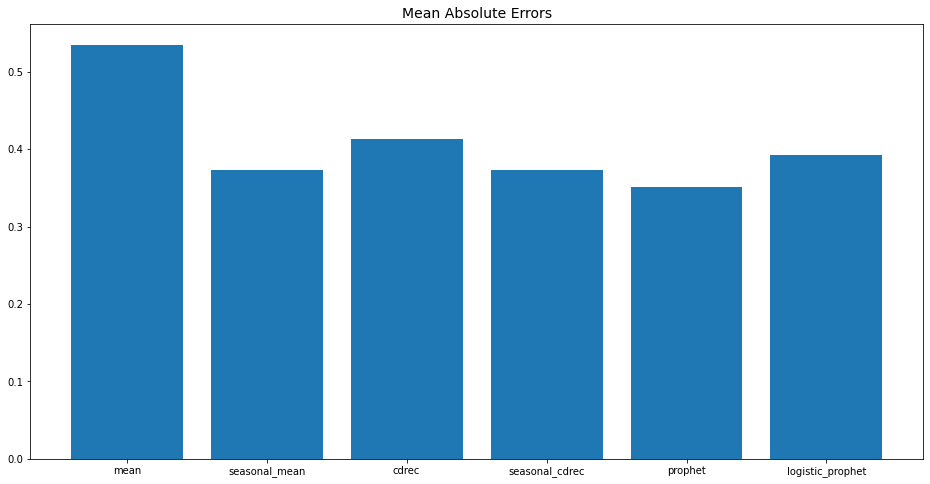

In [66]:
x_axis = list(mae_scores.keys())
fig, ax = plt.subplots(1, 1, figsize=(16,8), sharex=True);
ax.bar(x=x_axis, height=mae_scores.values());
plt.title('Mean Absolute Errors', fontsize=14);

In [67]:
print(f"The best mean squared error score is {min(mse_scores, key=mse_scores.get)} " \
      + f"with a value of {min(mse_scores.values()):0.3f}")
print(f"The best mean absolute error score is {min(mae_scores, key=mae_scores.get)} " \
      + f"with a value of {min(mae_scores.values()):0.3f}")

The best mean squared error score is seasonal_mean with a value of 0.016
The best mean absolute error score is prophet with a value of 0.352


There are only marginal differences between the seasonal mean method and Prophet. We will prefer the simpler technique (seasonal mean).

In [68]:
nonimputed_train_file_name = 'Data/nonimputed_train.pkl'
train_df.to_pickle(nonimputed_train_file_name)
test_file_name = 'Data/test.pkl'
test_df.to_pickle(test_file_name)

In [69]:
nonimputed_full_file_name = 'Data/nonimputed.pkl'
two_way_volume_1M_df.to_pickle(nonimputed_full_file_name)

In [70]:
imputed_df = mean_seasonal(train_df)

In [71]:
imputed_file_name = 'Data/imputed_train.pkl'
imputed_df.to_pickle(imputed_file_name)

In [72]:
imputed_full_file_name = 'Data/imputed.pkl'
imputed_full_df = pd.concat([imputed_df, test_df])
imputed_full_df.to_pickle(imputed_full_file_name)

In [33]:
def mean_full_test_train(train_df, test_df):
    tr_df = train_df.copy()
    te_df = test_df.copy()
    tr_df.fillna(tr_df.mean(), inplace=True)
    te_df.fillna(tr_df.mean(), inplace=True)
    return pd.concat([tr_df, te_df])

In [35]:
def mean_seasonal_test_train(train_df, test_df):
    tr_df = train_df.copy()
    te_df = test_df.copy()    
    tr_subframes = seasonal_split(tr_df)
    te_subframes = seasonal_split(te_df)
    
    recovered_frames = []
    for sub_tr_df, sub_te_df in zip(tr_subframes, te_subframes):
        recovered = mean_full_test_train(sub_tr_df, sub_te_df)
        recovered_frames.append(recovered)
        
    recovered_df = pd.concat(recovered_frames)
    recovered_df.sort_index(inplace=True)

    return recovered_df

In [40]:
test_train_imputed_df = mean_seasonal_test_train(train_df, test_df)

In [41]:
test_train_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 230 entries, 2002-01-31 to 2021-02-28
Data columns (total 84 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   26      230 non-null    float64
 1   27      230 non-null    float64
 2   28      230 non-null    float64
 3   29      230 non-null    float64
 4   31      230 non-null    float64
 5   32      230 non-null    float64
 6   33      230 non-null    float64
 7   34      230 non-null    float64
 8   35      230 non-null    float64
 9   38      230 non-null    float64
 10  39      230 non-null    float64
 11  40      230 non-null    float64
 12  41      230 non-null    float64
 13  42      230 non-null    float64
 14  43      230 non-null    float64
 15  44      230 non-null    float64
 16  45      230 non-null    float64
 17  46      230 non-null    float64
 18  51      230 non-null    float64
 19  103     230 non-null    float64
 20  110     230 non-null    float64
 21  164     230 non-null

In [42]:
tt_imputed_full_file_name = 'Data/test_train_imputed.pkl'
test_train_imputed_df.to_pickle(tt_imputed_full_file_name)